# **스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 다음의 두가지 방법 중 하나를 선택하여 폴더를 준비하고 데이터를 로딩하시오.
        * 1) 로컬 수행(Ananconda)
            * 제공된 압축파일을 다운받아 압축을 풀고
            * anaconda의 root directory(보통 C:/Users/< ID > 에 project 폴더를 만들고, 복사해 넣습니다.
        * 2) 구글콜랩
            * 구글 드라이브 바로 밑에 project 폴더를 만들고, 
            * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다. 
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

#### 1) 로컬 수행(Anaconda)
* project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [3]:
path = 'C:/Users/User/Desktop/KT AIVLE/미니프로젝트 3차/실습자료_에이블러용'

#### 2) 구글 콜랩 수행

* 구글 드라이브 연결

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# path = '/content/drive/MyDrive/project/'

### (2) 라이브러리 설치 및 불러오기

1) 라이브러리 로딩

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#필요하다고 판단되는 라이브러리를 추가하세요.

#### 3) 제공 함수 생성
* 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
* 입력 : 
    * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
    * names : 변수 이름 목록(예 : x_train.columns
    * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
    * topn : 중요도 상위 n개만 표시. all 이면 전체.
* 출력 : 
    * 중요도 그래프 : 중요도 내림차순으로 정렬
    * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [7]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

In [8]:
data_train = pd.read_csv('data01_train.csv')
data_train.drop('subject', axis=1, inplace=True)
data_train['Activity'] = data_train['Activity'].astype('category')

In [9]:
data_test = pd.read_csv('data01_test.csv')
data_test.drop('subject', axis=1, inplace=True)
data_test['Activity'] = data_test['Activity'].astype('category')

In [10]:
features = pd.read_csv('features.csv')

In [11]:
display(data_train, data_test)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.305772,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.622617,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.597610,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,0.196921,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,WALKING_UPSTAIRS


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1466,0.278725,-0.015262,-0.106398,-0.993625,-0.982845,-0.974745,-0.993963,-0.981100,-0.974596,-0.939303,...,-0.586580,-0.874066,-0.054788,0.712975,0.300318,-0.319188,-0.857336,0.120184,0.119276,SITTING
1467,0.275803,-0.019257,-0.109078,-0.998614,-0.991621,-0.987403,-0.998813,-0.991503,-0.986802,-0.945442,...,-0.451941,-0.721050,0.076333,-0.021599,-0.277268,0.754011,-0.764185,0.212111,0.138595,STANDING
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.213340,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS
1469,0.135873,-0.020675,-0.116644,-0.960526,-0.955134,-0.985818,-0.963115,-0.971338,-0.988261,-0.946289,...,0.072602,-0.422383,-0.048474,0.236761,-0.186581,0.396648,0.790877,-0.474618,-0.505953,LAYING


In [12]:
features.tail()

,sensor,agg,axis,feature_name
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"
560,angle,Z,gravityMean,"angle(Z,gravityMean)"


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [13]:
print(data_train.shape)
display(data_train.describe())
print(data_train.info())

(5881, 562)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: category(1), float64(561)
memory usage: 25.2 MB
None


In [14]:
print(data_test.shape)
display(data_test.describe())
print(data_test.info())

(1471, 562)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,...,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000,1471.000000
mean,0.273198,-0.017281,-0.108123,-0.614634,-0.515427,-0.607533,-0.639950,-0.530760,-0.609256,-0.481055,...,0.118651,-0.311513,-0.632273,0.009324,0.015666,0.006272,-0.001510,-0.481737,0.055771,-0.064194
std,0.079989,0.045957,0.049082,0.448480,0.506094,0.424243,0.422994,0.489381,0.418536,0.542756,...,0.258112,0.313792,0.296179,0.324864,0.452616,0.608954,0.483028,0.522714,0.298124,0.281645
min,-1.000000,-1.000000,-0.418354,-0.999717,-0.999873,-1.000000,-0.999867,-1.000000,-0.999879,-0.948723,...,-1.000000,-0.995357,-0.994664,-0.937468,-0.990492,-0.995222,-0.969066,-0.999380,-0.995073,-1.000000
25%,0.263787,-0.024792,-0.120733,-0.992669,-0.979082,-0.981070,-0.993498,-0.979214,-0.980659,-0.936791,...,-0.035193,-0.546342,-0.844547,-0.119166,-0.265533,-0.485998,-0.380300,-0.814060,-0.017413,-0.148445
50%,0.277322,-0.017187,-0.108124,-0.952426,-0.867309,-0.869890,-0.958705,-0.873891,-0.863451,-0.890491,...,0.135282,-0.347433,-0.706699,0.005049,0.023421,-0.005036,0.002408,-0.708911,0.178814,-0.002243
75%,0.288058,-0.010238,-0.096606,-0.245405,-0.030639,-0.260223,-0.297260,-0.058824,-0.256657,-0.030692,...,0.289832,-0.125796,-0.516910,0.135698,0.312690,0.518184,0.374583,-0.486534,0.248126,0.096674
max,0.631510,0.359587,0.543939,0.899922,0.782590,0.931308,0.950758,0.602458,0.784041,0.821218,...,0.860512,0.941113,0.894210,0.980889,0.991899,0.994366,0.979522,1.000000,0.432496,0.992766


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1471 entries, 0 to 1470
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: category(1), float64(561)
memory usage: 6.3 MB
None


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

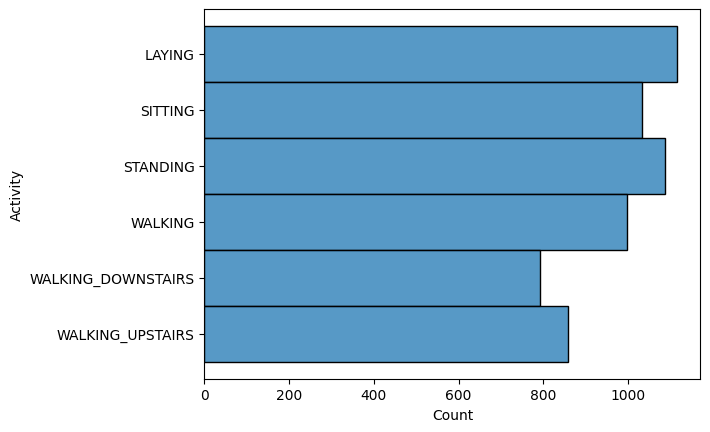

In [15]:
sns.histplot(y='Activity', data=data_train)
plt.show()

In [16]:
data_train['Activity'].value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [17]:
features.tail()

,sensor,agg,axis,feature_name
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)"
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)"
558,angle,X,gravityMean,"angle(X,gravityMean)"
559,angle,Y,gravityMean,"angle(Y,gravityMean)"
560,angle,Z,gravityMean,"angle(Z,gravityMean)"


In [18]:
features.groupby(by='sensor', as_index=False)['feature_name'].count()

,sensor,feature_name
0,angle,7
1,fBodyAcc,79
2,fBodyAccJerk,79
3,fBodyAccMag,13
4,fBodyBodyAccJerkMag,13
5,fBodyBodyGyroJerkMag,13
6,fBodyBodyGyroMag,13
7,fBodyGyro,79
8,tBodyAcc,40
9,tBodyAccJerk,40


In [19]:
features.groupby(by='agg', as_index=False)['feature_name'].count()

,agg,feature_name
0,X,1
1,Y,1
2,Z,1
3,arCoeff(),60
4,arCoeff()1,5
5,arCoeff()2,5
6,arCoeff()3,5
7,arCoeff()4,5
8,bandsEnergy(),126
9,correlation(),15


In [20]:
features.groupby(by='axis', as_index=False)['feature_name'].count()

,axis,feature_name
0,"1,16",5
1,"1,16.1",2
2,"1,16.2",2
3,"1,24",5
4,"1,24.1",2
...,...,...
57,"Z,2",5
58,"Z,3",5
59,"Z,4",5
60,gravity,1


## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

#### 1) 데이터 전처리

In [21]:
data_test.loc[:, data_test.isnull().sum() != 0]

""
0
1
2
3
4
...
1466
1467
1468
1469


널값은 없음.

In [22]:
from sklearn.model_selection import train_test_split

x = data_train.drop('Activity', axis=1)
y = data_train['Activity']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

#### 2) 모델링

In [23]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(max_depth=5, random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1)

#### 3) 변수 중요도 추출

In [24]:
feature_importance = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance
importance.tail()

,feature_name,feature_importance
556,"angle(tBodyGyroMean,gravityMean)",0.000169
557,"angle(tBodyGyroJerkMean,gravityMean)",0.000087
558,"angle(X,gravityMean)",0.044580
559,"angle(Y,gravityMean)",0.018203
560,"angle(Z,gravityMean)",0.007051


### (2) 중요도 기반 feature 분석

* **세부 요구사항**
    - 상위 n, 하위 m 개의 변수를 선정
    - 선정된 변수(feature)와 target 간의 관계를 kdeplot으로 그리기

#### 1) 상위 5, 하위 5개 변수 선정

In [25]:
importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())
up5 = np.array(importance.head()['feature_name'])

,feature_name,feature_importance
558,"angle(X,gravityMean)",0.044580
56,tGravityAcc-energy()-X,0.041135
52,tGravityAcc-min()-X,0.034969
40,tGravityAcc-mean()-X,0.032965
53,tGravityAcc-min()-Y,0.025315


#### 2) 상위 5개 변수에 대한 분석

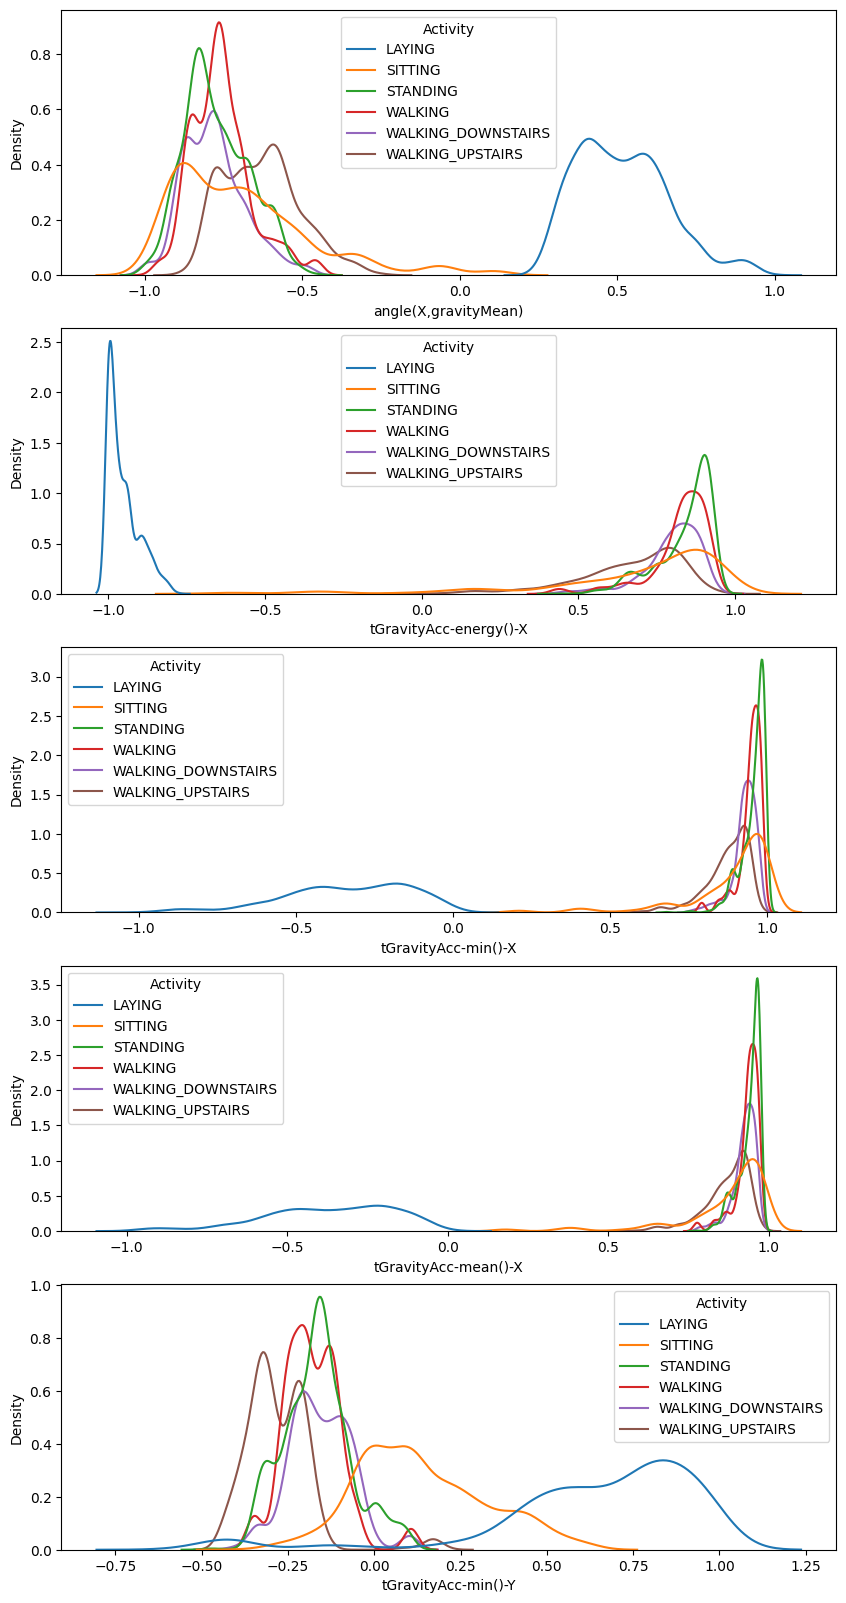

In [26]:
plt.figure(figsize=(10,20))

for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='Activity', data=data_train)
plt.show()

#### 3) 하위 5개 변수에 대한 분석

In [27]:
display(importance.tail())
down5 = np.array(importance.tail()['feature_name'])

,feature_name,feature_importance
345,fBodyAccJerk-mean()-Y,0.0
32,"tBodyAcc-arCoeff()-Y,4",0.0
349,fBodyAccJerk-std()-Z,0.0
30,"tBodyAcc-arCoeff()-Y,2",0.0
0,tBodyAcc-mean()-X,0.0


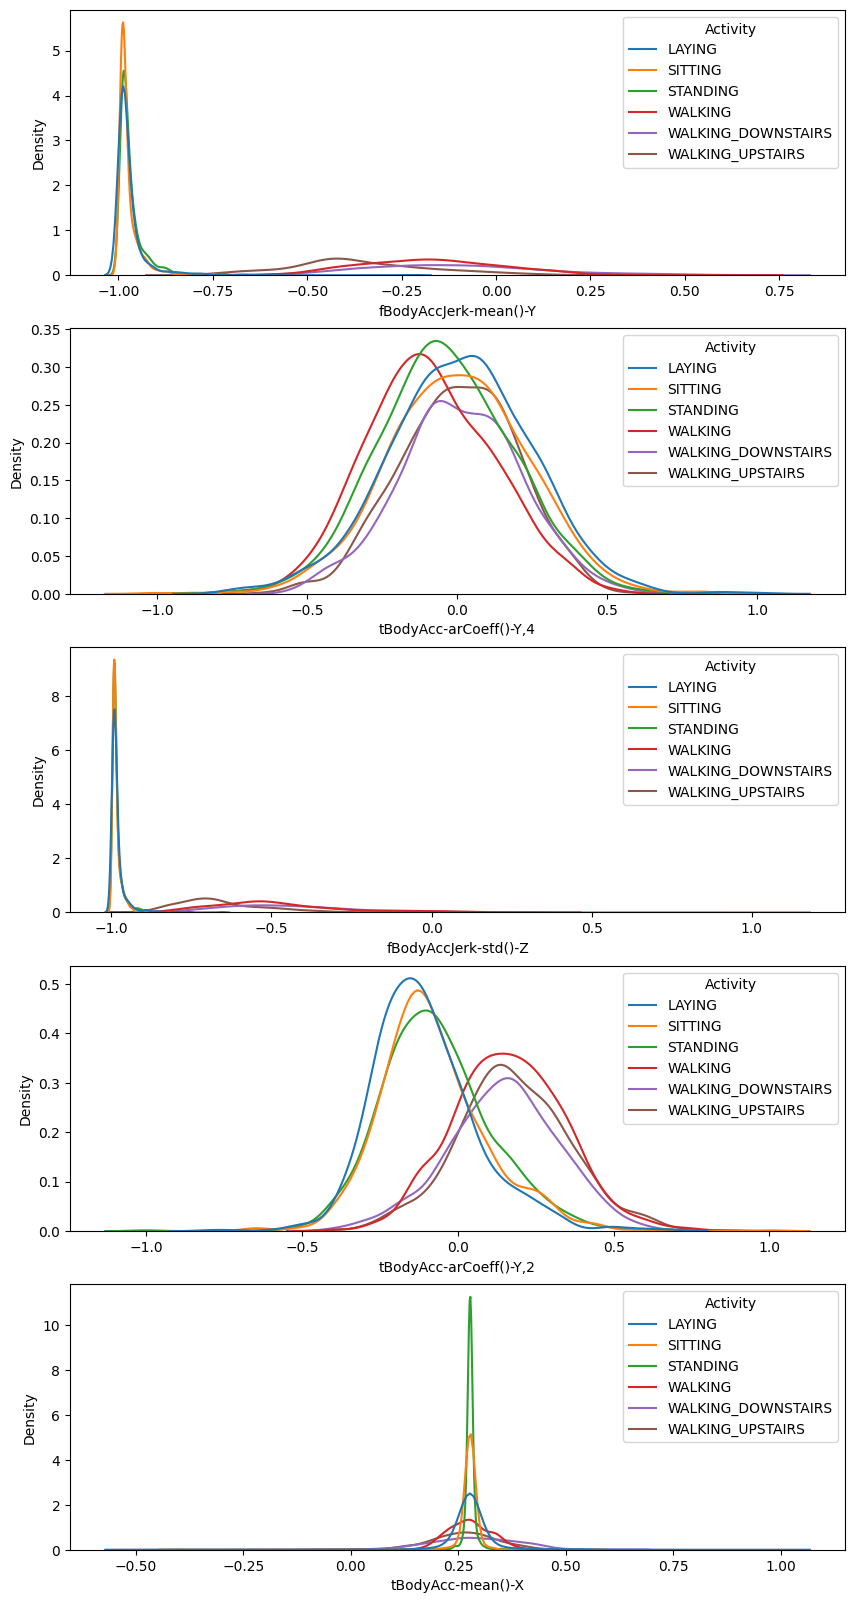

In [28]:
plt.figure(figsize=(10,20))

for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=down5[i], hue='Activity', data=data_train)
plt.show()

### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


#### 1) 결과 merge

In [29]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000169
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000087
558,angle,X,gravityMean,"angle(X,gravityMean)",0.044580
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.018203
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.007051


#### 2) sensor 별 중요도 합계

<Axes: ylabel='sensor'>

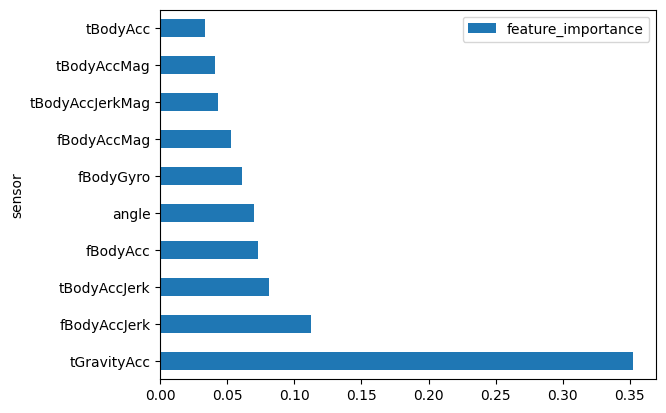

In [30]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

#### 3) sensor + agg 별 중요도 합계

<Axes: ylabel='together'>

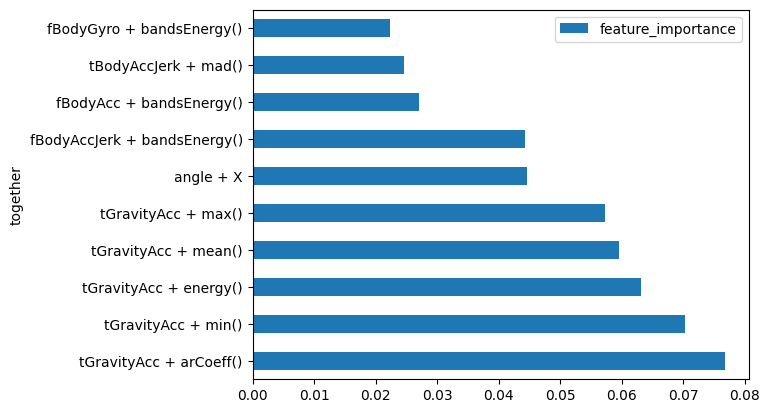

In [31]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

## 4.데이터 분석 : 미션2

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 targe을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [32]:
dynamic = data_train.copy()
dynamic['is_dynamic'] = dynamic['Activity'].replace({'STANDING': 0,
                                                     'SITTING': 0,
                                                     'LAYING': 0,
                                                     'WALKING': 1,
                                                     'WALKING_UPSTAIRS': 1,
                                                     'WALKING_DOWNSTAIRS': 1})

print(dynamic['Activity'].value_counts())
print(dynamic['is_dynamic'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_dynamic
0    3234
1    2647
Name: count, dtype: int64


#### 2) 기본모델 생성

In [33]:
x = dynamic.drop(['Activity', 'is_dynamic'], axis=1)
y = dynamic['is_dynamic']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [34]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [35]:
feature_importance_dynamic = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_dynamic

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
350,fBodyAccJerk-mad()-X,0.069982
389,"fBodyAccJerk-bandsEnergy()-1,16",0.050165
96,tBodyAccJerk-energy()-X,0.050036
86,tBodyAccJerk-mad()-X,0.049927
83,tBodyAccJerk-std()-X,0.039999


* 상위 변수 선정

In [36]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['fBodyAccJerk-mad()-X', 'fBodyAccJerk-bandsEnergy()-1,16',
       'tBodyAccJerk-energy()-X', 'tBodyAccJerk-mad()-X',
       'tBodyAccJerk-std()-X'], dtype=object)

In [ ]:
def model_pipline(data):
    

* 데이터 탐색하기

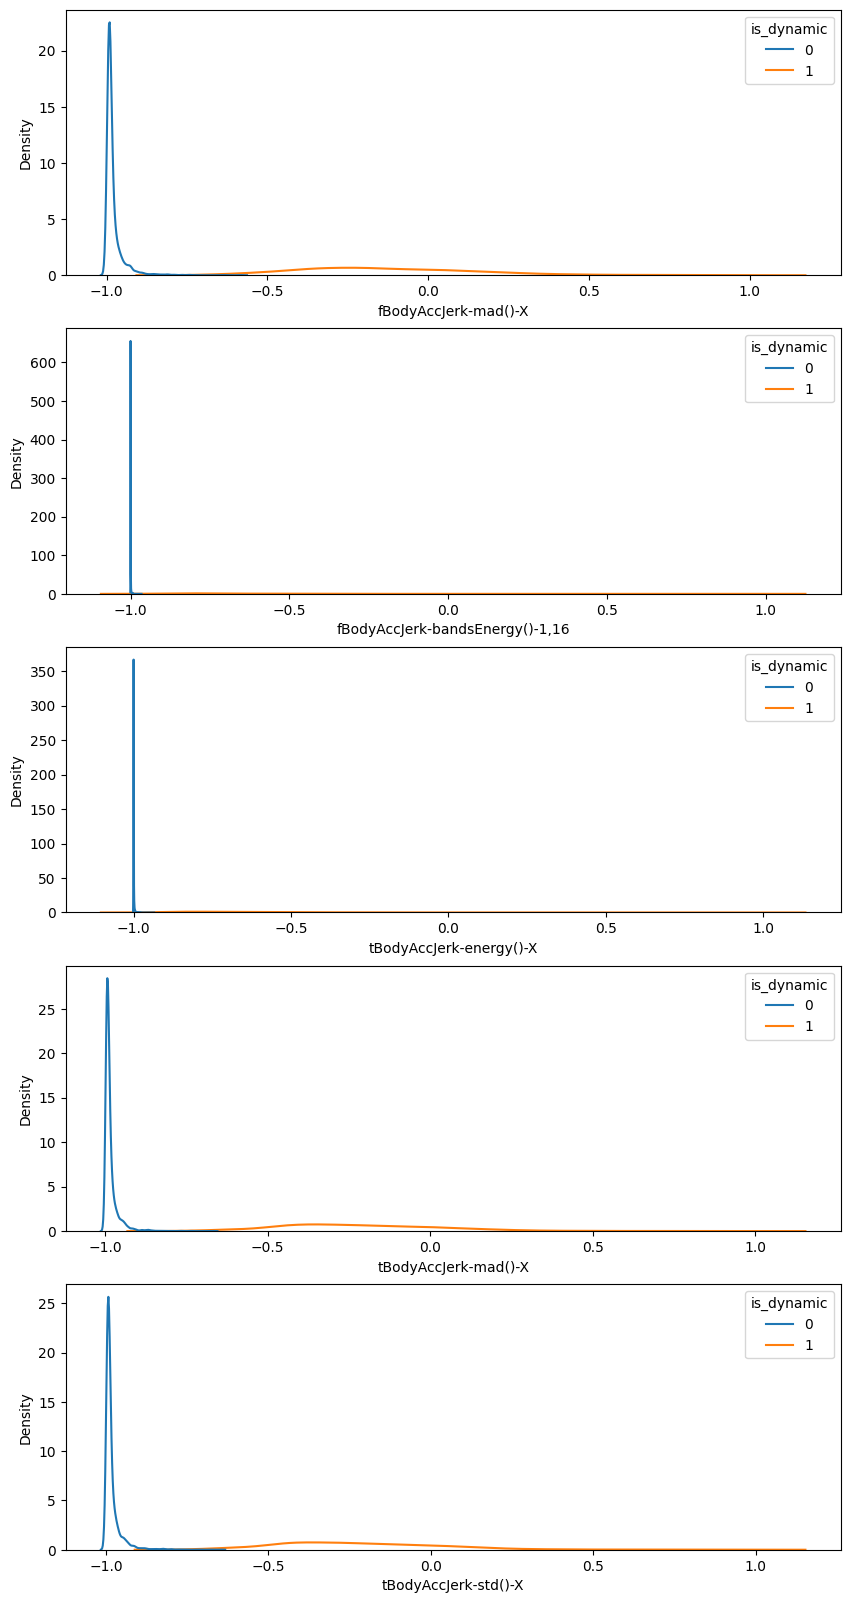

In [37]:
plt.figure(figsize=(10,20))

for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_dynamic', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [38]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000219
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.000028
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.000100


* sensor 별 중요도

<Axes: ylabel='sensor'>

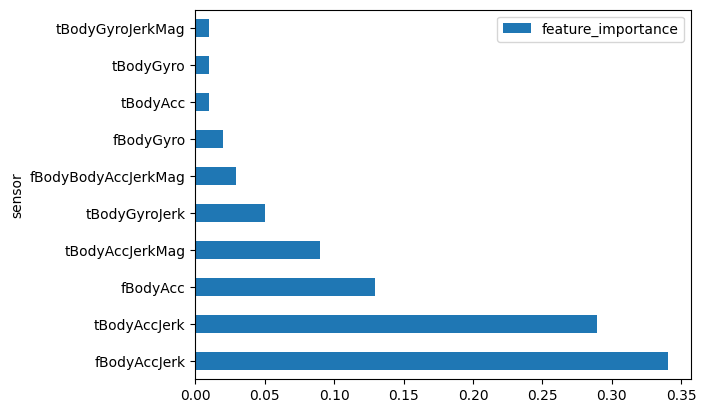

In [39]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

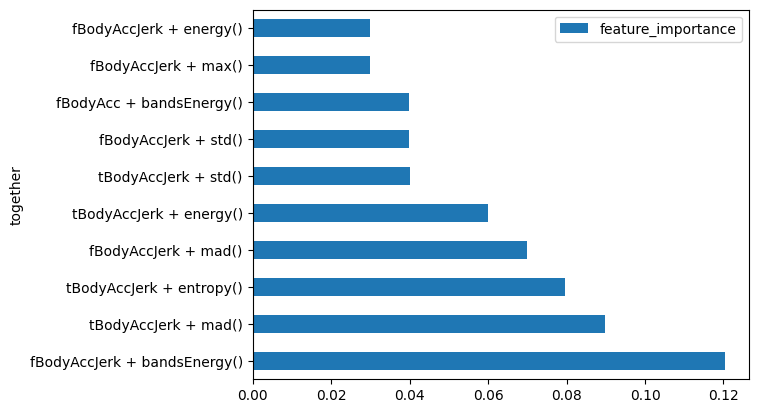

In [40]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_standing 추가

In [41]:
dynamic['is_standing'] = dynamic['Activity'].replace({'STANDING': 1,
                                                      'SITTING': 0,
                                                      'LAYING': 0,
                                                      'WALKING': 0,
                                                      'WALKING_UPSTAIRS': 0,
                                                      'WALKING_DOWNSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_standing'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_standing
0    4794
1    1087
Name: count, dtype: int64


#### 2) 기본모델 생성

In [42]:
x = dynamic.drop(['Activity', 'is_dynamic', 'is_standing'], axis=1)
y = dynamic['is_standing']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [43]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [44]:
feature_importance_standing = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_standing

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
53,tGravityAcc-min()-Y,0.056396
559,"angle(Y,gravityMean)",0.056257
50,tGravityAcc-max()-Y,0.054457
41,tGravityAcc-mean()-Y,0.054186
558,"angle(X,gravityMean)",0.031465


* 상위 변수 선정

In [45]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['tGravityAcc-min()-Y', 'angle(Y,gravityMean)',
       'tGravityAcc-max()-Y', 'tGravityAcc-mean()-Y',
       'angle(X,gravityMean)'], dtype=object)

* 데이터 탐색하기
* 변수 중요도 상위 5개의 변수 분포 파악

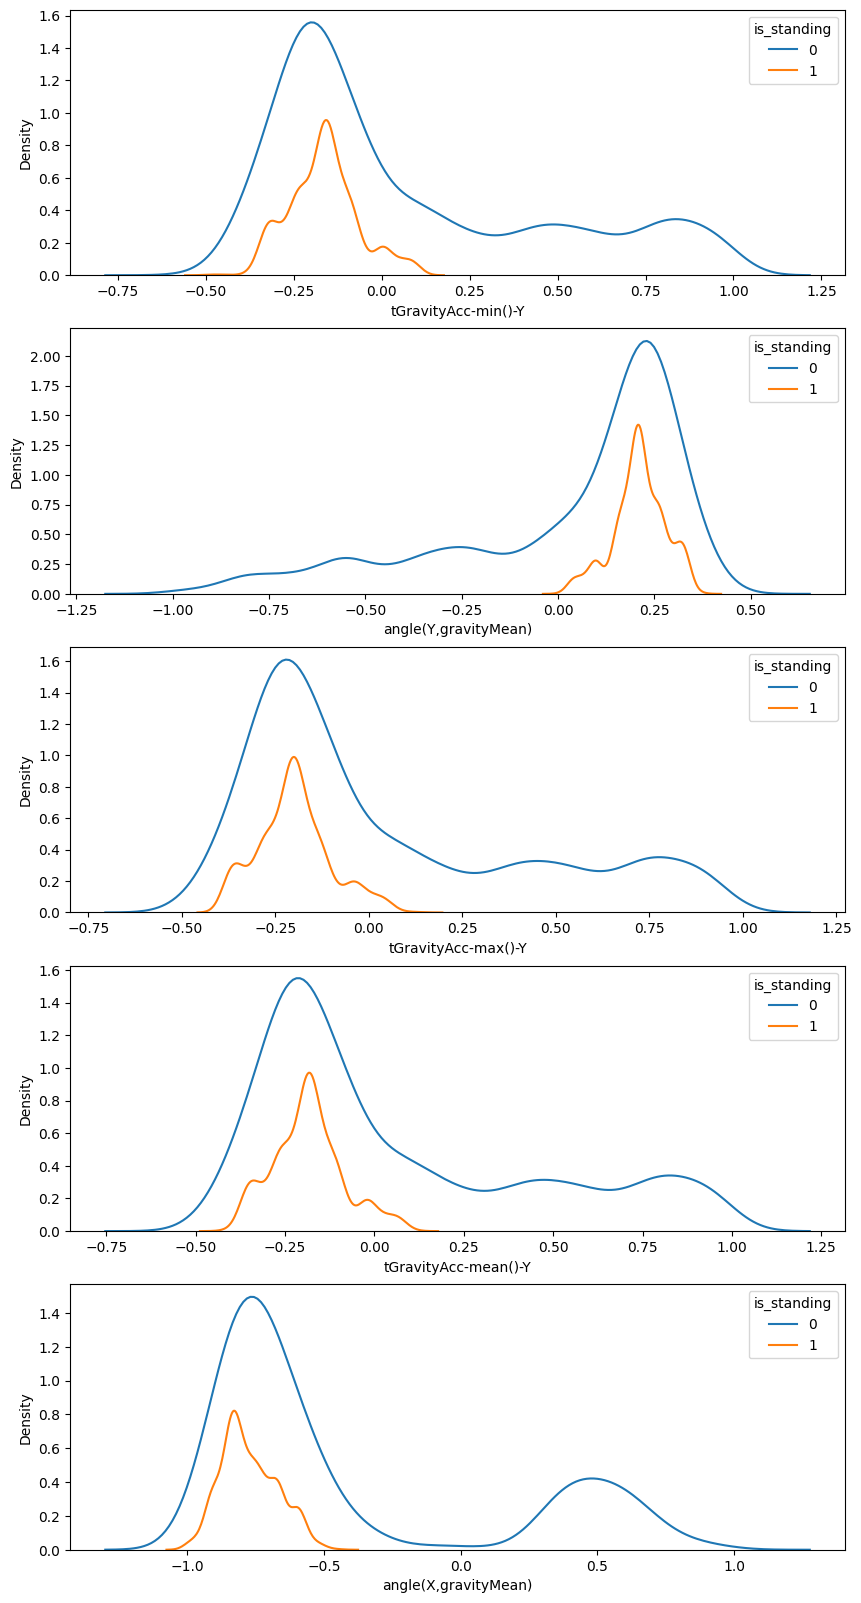

In [46]:
plt.figure(figsize=(10,20))

for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_standing', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [47]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000689
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.002007
558,angle,X,gravityMean,"angle(X,gravityMean)",0.031465
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.056257
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.022299


* sensor 별 중요도

<Axes: ylabel='sensor'>

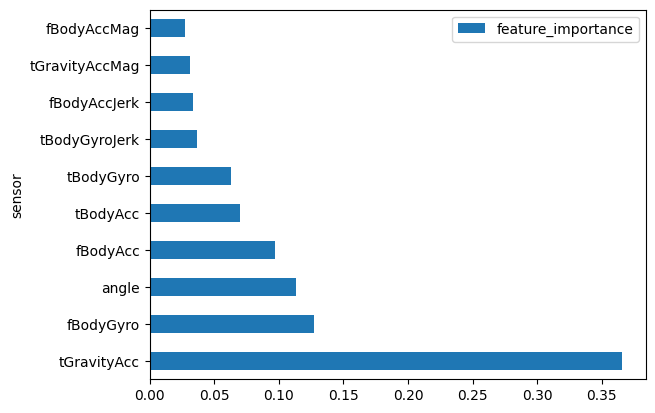

In [48]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

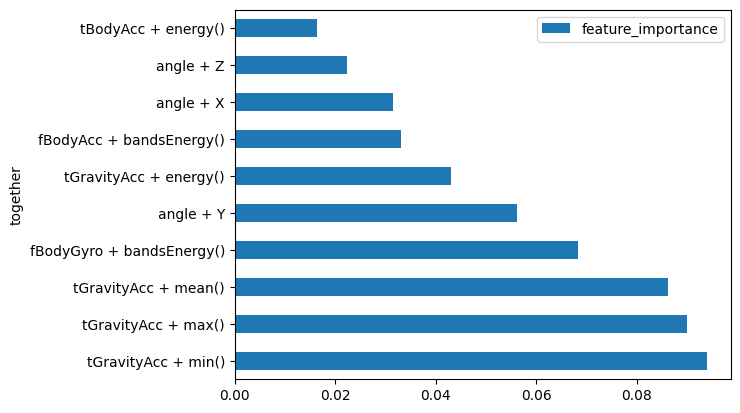

In [49]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_sitting 추가

In [50]:
dynamic['is_sitting'] = dynamic['Activity'].replace({'SITTING': 1,
                                                      'STANDING': 0,
                                                      'LAYING': 0,
                                                      'WALKING': 0,
                                                      'WALKING_UPSTAIRS': 0,
                                                      'WALKING_DOWNSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_sitting'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_sitting
0    4849
1    1032
Name: count, dtype: int64


#### 2) 기본모델 생성

In [51]:
x = dynamic.drop(['Activity','is_dynamic', 'is_standing', 'is_sitting'], axis=1)
y = dynamic['is_sitting']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [52]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [53]:
feature_importance_sitting = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_sitting

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
53,tGravityAcc-min()-Y,0.050450
41,tGravityAcc-mean()-Y,0.039463
50,tGravityAcc-max()-Y,0.038749
56,tGravityAcc-energy()-X,0.030520
558,"angle(X,gravityMean)",0.030515


* 상위 변수 선정

In [54]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['tGravityAcc-min()-Y', 'tGravityAcc-mean()-Y',
       'tGravityAcc-max()-Y', 'tGravityAcc-energy()-X',
       'angle(X,gravityMean)'], dtype=object)

* 데이터 탐색하기

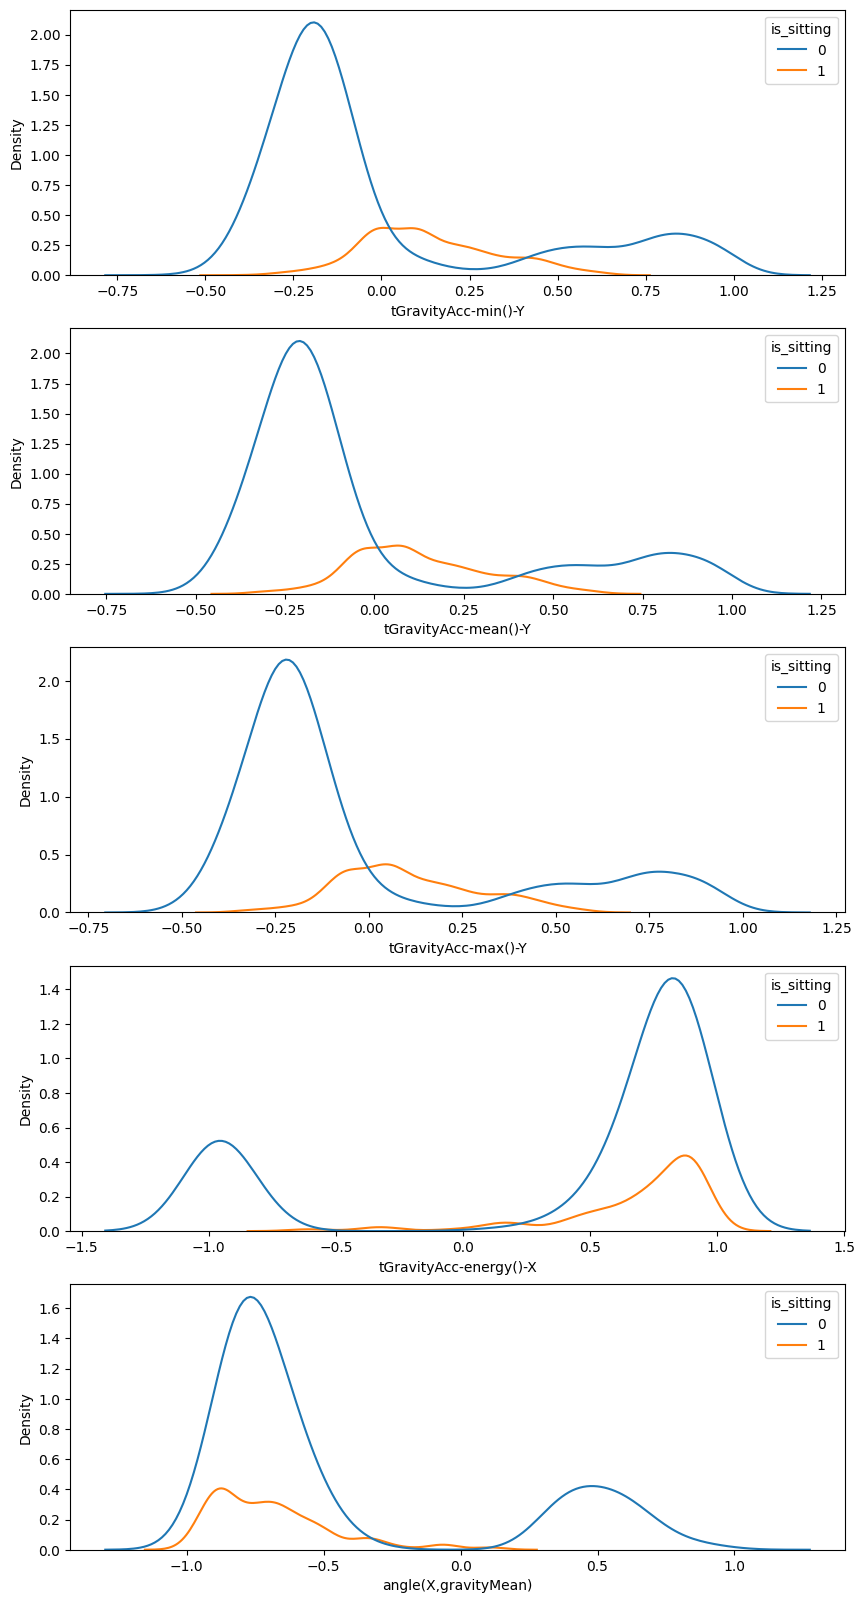

In [55]:
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_sitting', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [56]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.001376
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.001857
558,angle,X,gravityMean,"angle(X,gravityMean)",0.030515
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.023097
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.012251


* sensor 별 중요도

<Axes: ylabel='sensor'>

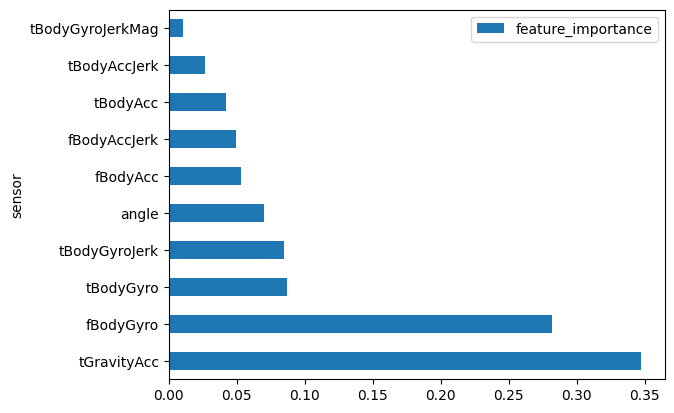

In [57]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

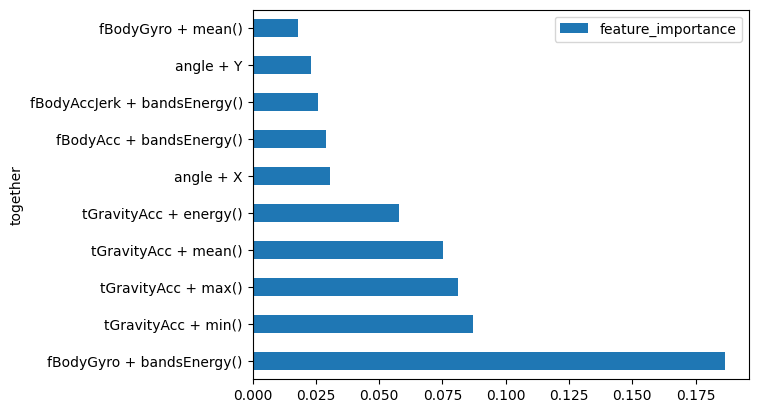

In [58]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_laying 추가

In [59]:
dynamic['is_laying'] = dynamic['Activity'].replace({'LAYING': 1,
                                                      'STANDING': 0,
                                                      'SITTING': 0,
                                                      'WALKING': 0,
                                                      'WALKING_UPSTAIRS': 0,
                                                      'WALKING_DOWNSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_laying'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_laying
0    4766
1    1115
Name: count, dtype: int64


#### 2) 기본모델 생성

In [60]:
x = dynamic.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying'], axis=1)
y = dynamic['is_laying']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [61]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [62]:
feature_importance_laying = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_laying

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
558,"angle(X,gravityMean)",0.116279
56,tGravityAcc-energy()-X,0.095080
40,tGravityAcc-mean()-X,0.091985
52,tGravityAcc-min()-X,0.088408
49,tGravityAcc-max()-X,0.064866


* 상위 변수 선정

In [63]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['angle(X,gravityMean)', 'tGravityAcc-energy()-X',
       'tGravityAcc-mean()-X', 'tGravityAcc-min()-X',
       'tGravityAcc-max()-X'], dtype=object)

* 데이터 탐색하기

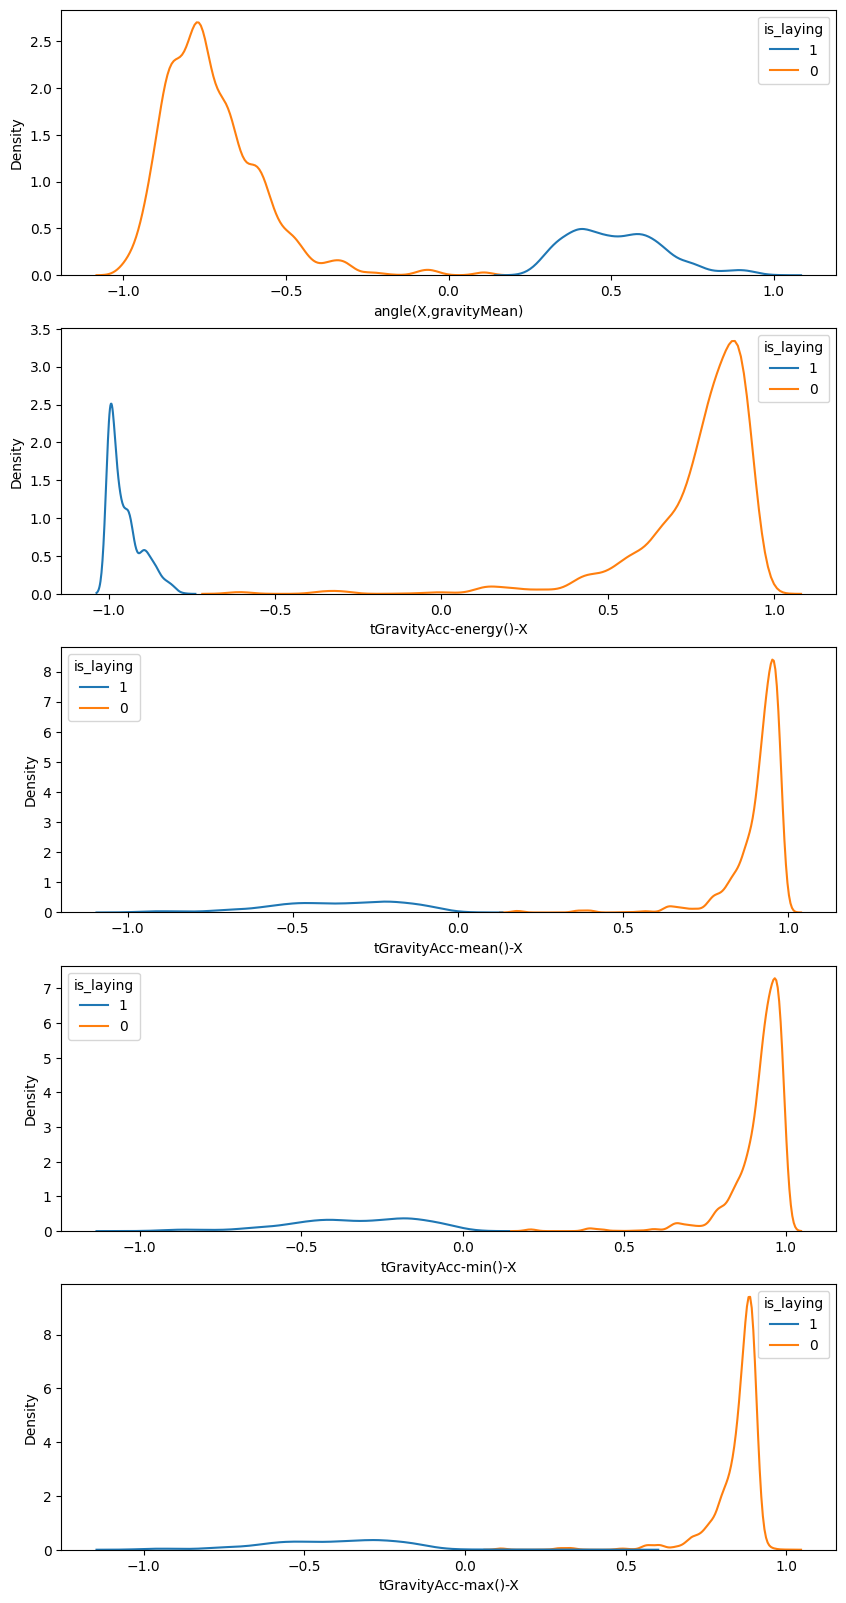

In [64]:
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_laying', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [65]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.116279
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.028595
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.014832


* sensor 별 중요도

<Axes: ylabel='sensor'>

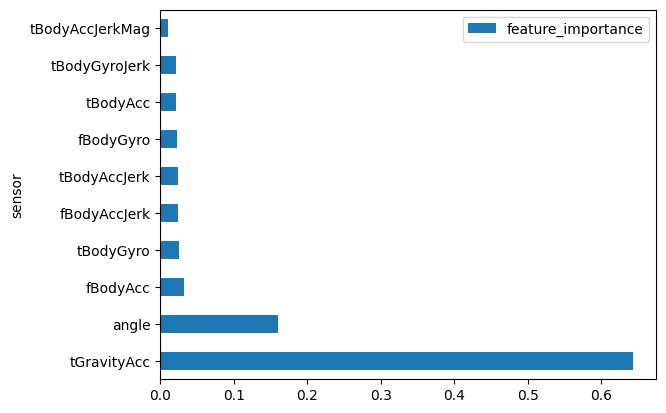

In [66]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

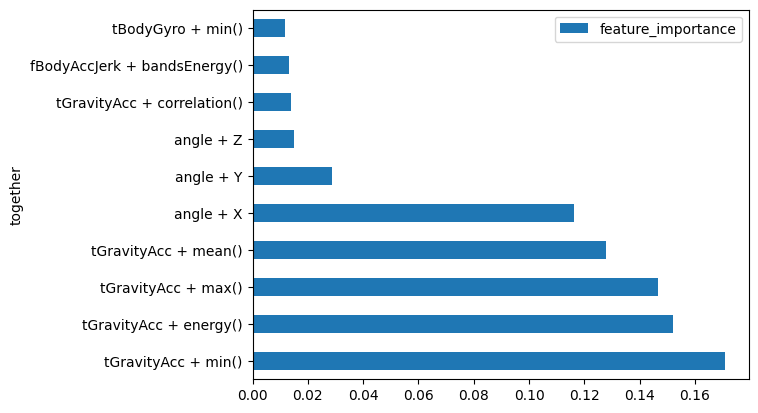

In [67]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking 추가

In [68]:
dynamic['is_walking'] = dynamic['Activity'].replace({'WALKING': 1,
                                                      'STANDING': 0,
                                                      'SITTING': 0,
                                                      'LAYING': 0,
                                                      'WALKING_UPSTAIRS': 0,
                                                      'WALKING_DOWNSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_laying'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_laying
0    4766
1    1115
Name: count, dtype: int64


#### 2) 기본모델 생성

In [69]:
x = dynamic.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking'], axis=1)
y = dynamic['is_walking']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [70]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [71]:
feature_importance_walking = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_walking

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
65,"tGravityAcc-arCoeff()-X,1",0.027485
274,fBodyAcc-max()-X,0.023283
201,tBodyAccMag-std(),0.023163
166,tBodyGyroJerk-mad()-X,0.019931
102,tBodyAccJerk-entropy()-X,0.018853


* 상위 변수 선정

In [72]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['tGravityAcc-arCoeff()-X,1', 'fBodyAcc-max()-X',
       'tBodyAccMag-std()', 'tBodyGyroJerk-mad()-X',
       'tBodyAccJerk-entropy()-X'], dtype=object)

* 데이터 탐색하기

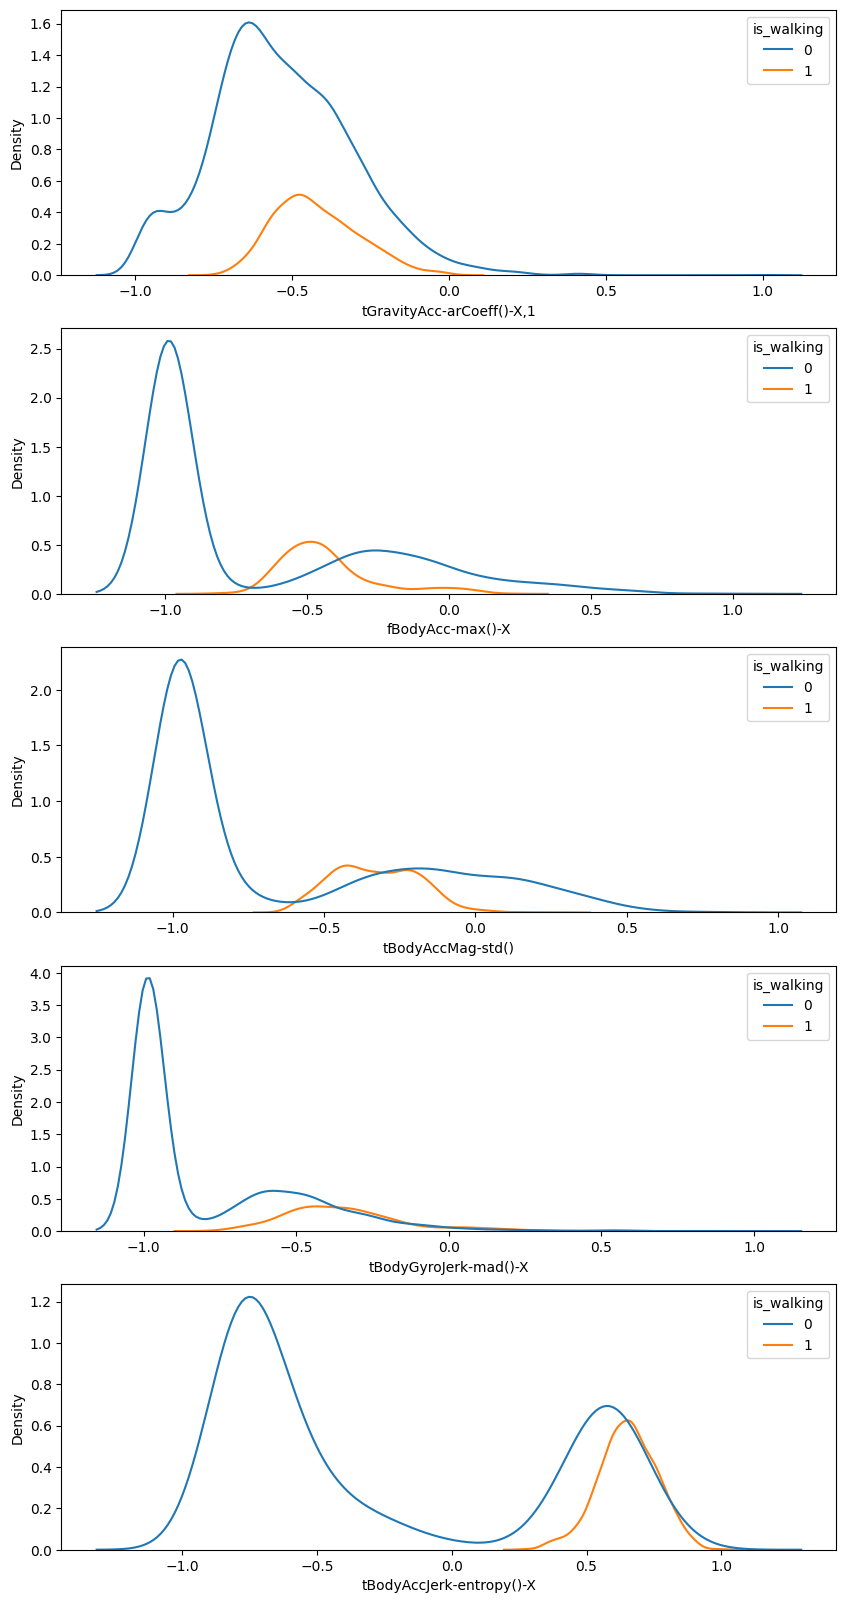

In [73]:
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_walking', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [74]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000375
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000137
558,angle,X,gravityMean,"angle(X,gravityMean)",0.001103
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.001168
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.000579


* sensor 별 중요도

<Axes: ylabel='sensor'>

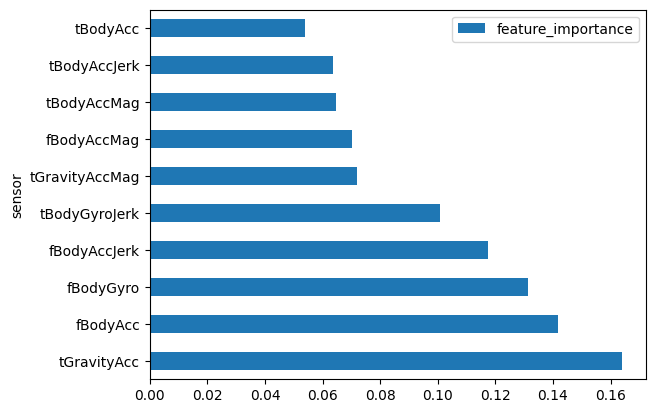

In [75]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

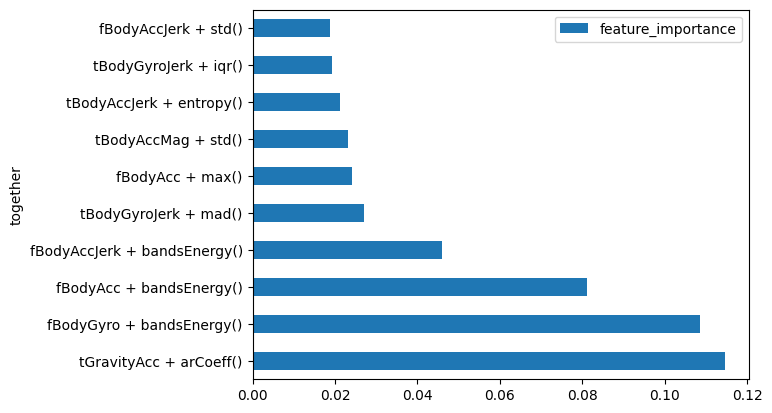

In [76]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_up 추가

In [77]:
dynamic['is_walking_UP'] = dynamic['Activity'].replace({'WALKING_UPSTAIRS': 1,
                                                      'STANDING': 0,
                                                      'SITTING': 0,
                                                      'LAYING': 0,
                                                      'WALKING': 0,
                                                      'WALKING_DOWNSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_walking_UP'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_walking_UP
0    5023
1     858
Name: count, dtype: int64


#### 2) 기본모델 생성

In [78]:
x = dynamic.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking', 'is_walking_UP'], axis=1)
y = dynamic['is_walking_UP']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [79]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [80]:
feature_importance_walkingup = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_walkingup

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
53,tGravityAcc-min()-Y,0.036041
73,"tGravityAcc-arCoeff()-Z,1",0.033158
76,"tGravityAcc-arCoeff()-Z,4",0.029458
295,fBodyAcc-meanFreq()-Z,0.023022
75,"tGravityAcc-arCoeff()-Z,3",0.021889


* 상위 변수 선정

In [81]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['tGravityAcc-min()-Y', 'tGravityAcc-arCoeff()-Z,1',
       'tGravityAcc-arCoeff()-Z,4', 'fBodyAcc-meanFreq()-Z',
       'tGravityAcc-arCoeff()-Z,3'], dtype=object)

* 데이터 탐색하기

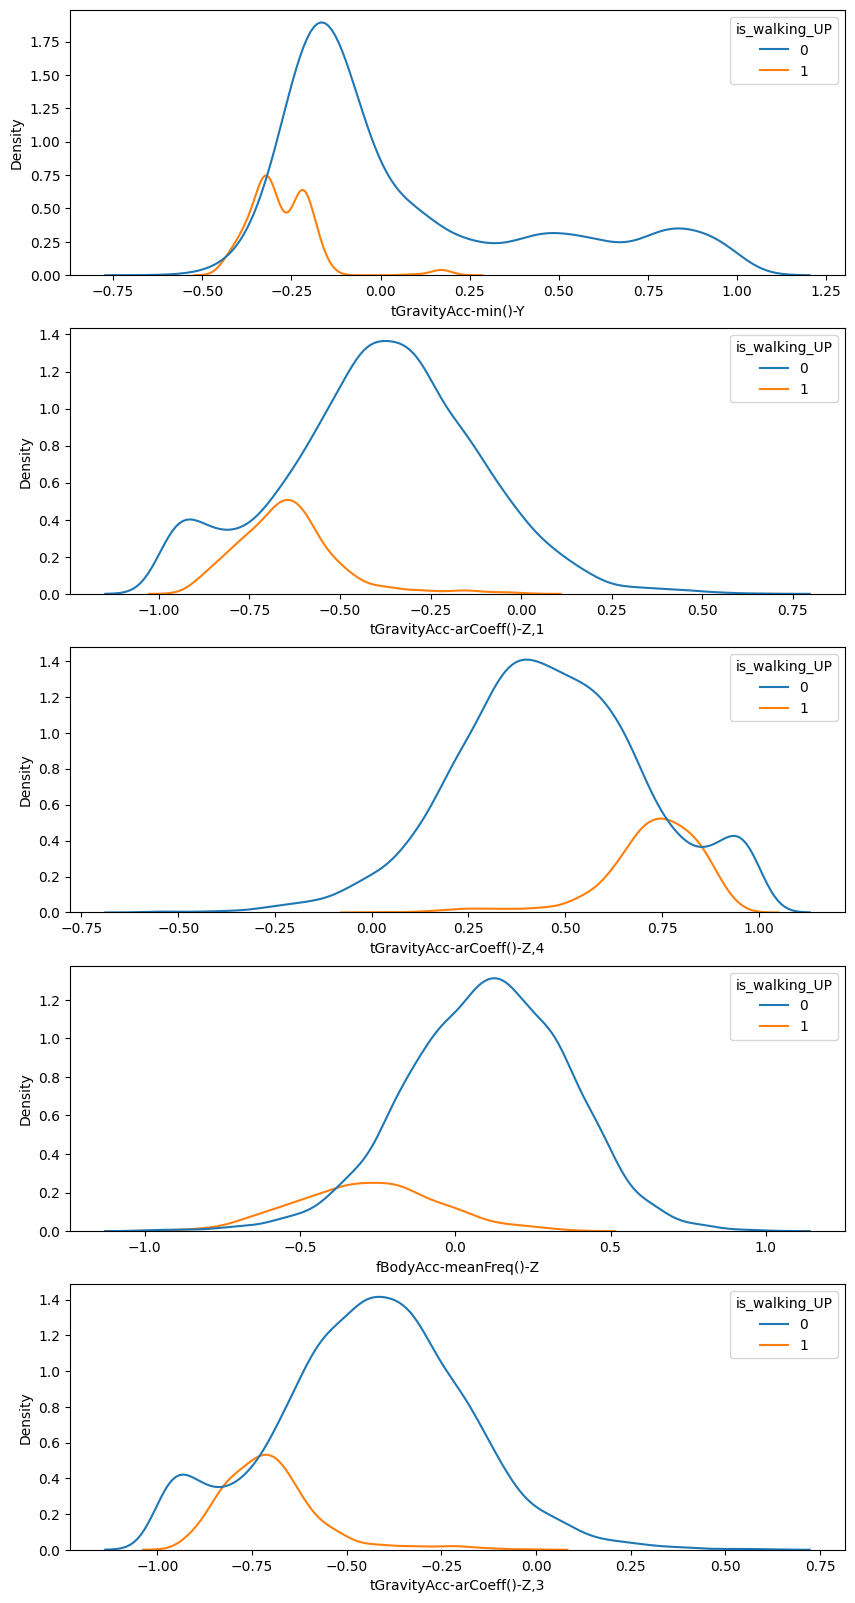

In [82]:
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_walking_UP', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [83]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000367
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000139
558,angle,X,gravityMean,"angle(X,gravityMean)",0.013487
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.016196
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.002529


* sensor 별 중요도

<Axes: ylabel='sensor'>

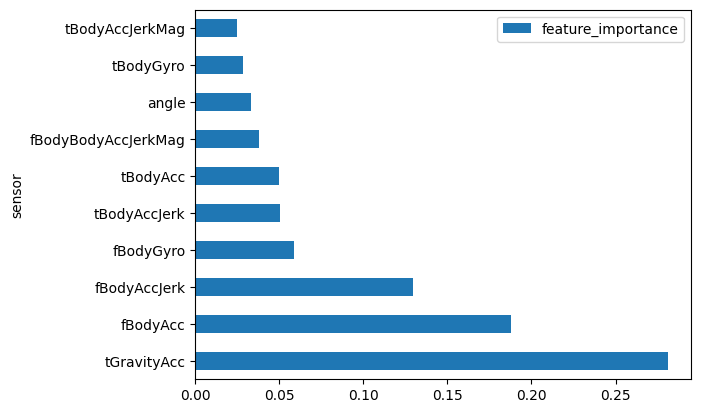

In [84]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

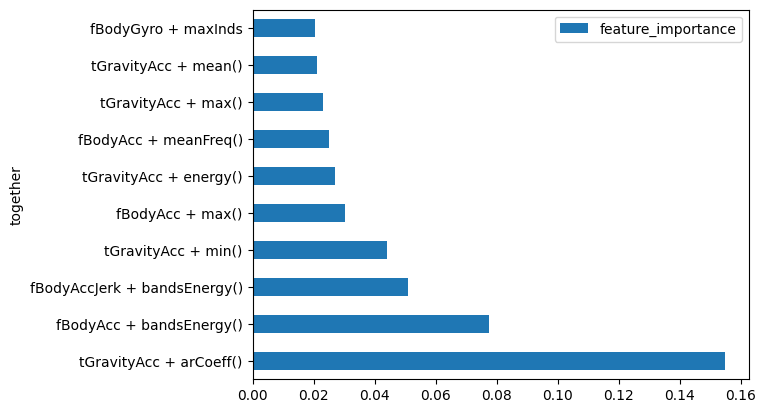

In [85]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_walking_down 추가

In [86]:
dynamic['is_walking_DOWN'] = dynamic['Activity'].replace({'WALKING_DOWNSTAIRS': 1,
                                                      'STANDING': 0,
                                                      'SITTING': 0,
                                                      'LAYING': 0,
                                                      'WALKING': 0,
                                                      'WALKING_UPSTAIRS': 0})
print(dynamic['Activity'].value_counts())
print(dynamic['is_walking_DOWN'].value_counts())

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64
is_walking_DOWN
0    5090
1     791
Name: count, dtype: int64


#### 2) 기본모델 생성

In [87]:
x = dynamic.drop(['Activity', 'is_dynamic', 'is_standing', 'is_sitting', 'is_laying', 'is_walking', 'is_walking_UP', 'is_walking_DOWN'], axis=1)
y = dynamic['is_walking_DOWN']
x_train, x_val , y_train, y_val = train_test_split(x, y, stratify=y, random_state=1)

In [88]:
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

#### 3) 변수중요도 상위 5개 분석

In [89]:
feature_importance_walkingdown = model_rf.feature_importances_

importance = pd.DataFrame()
importance['feature_name'] = list(x)
importance['feature_importance'] = feature_importance_walkingdown

importance.sort_values(by='feature_importance', ascending=False, inplace=True)
display(importance.head())

,feature_name,feature_importance
502,fBodyAccMag-mean(),0.045597
504,fBodyAccMag-mad(),0.042596
16,tBodyAcc-energy()-X,0.040851
214,tGravityAccMag-std(),0.037306
201,tBodyAccMag-std(),0.033766


* 상위 변수 선정

In [90]:
up5 = np.array(importance.head()['feature_name'])
up5

array(['fBodyAccMag-mean()', 'fBodyAccMag-mad()', 'tBodyAcc-energy()-X',
       'tGravityAccMag-std()', 'tBodyAccMag-std()'], dtype=object)

* 데이터 탐색하기

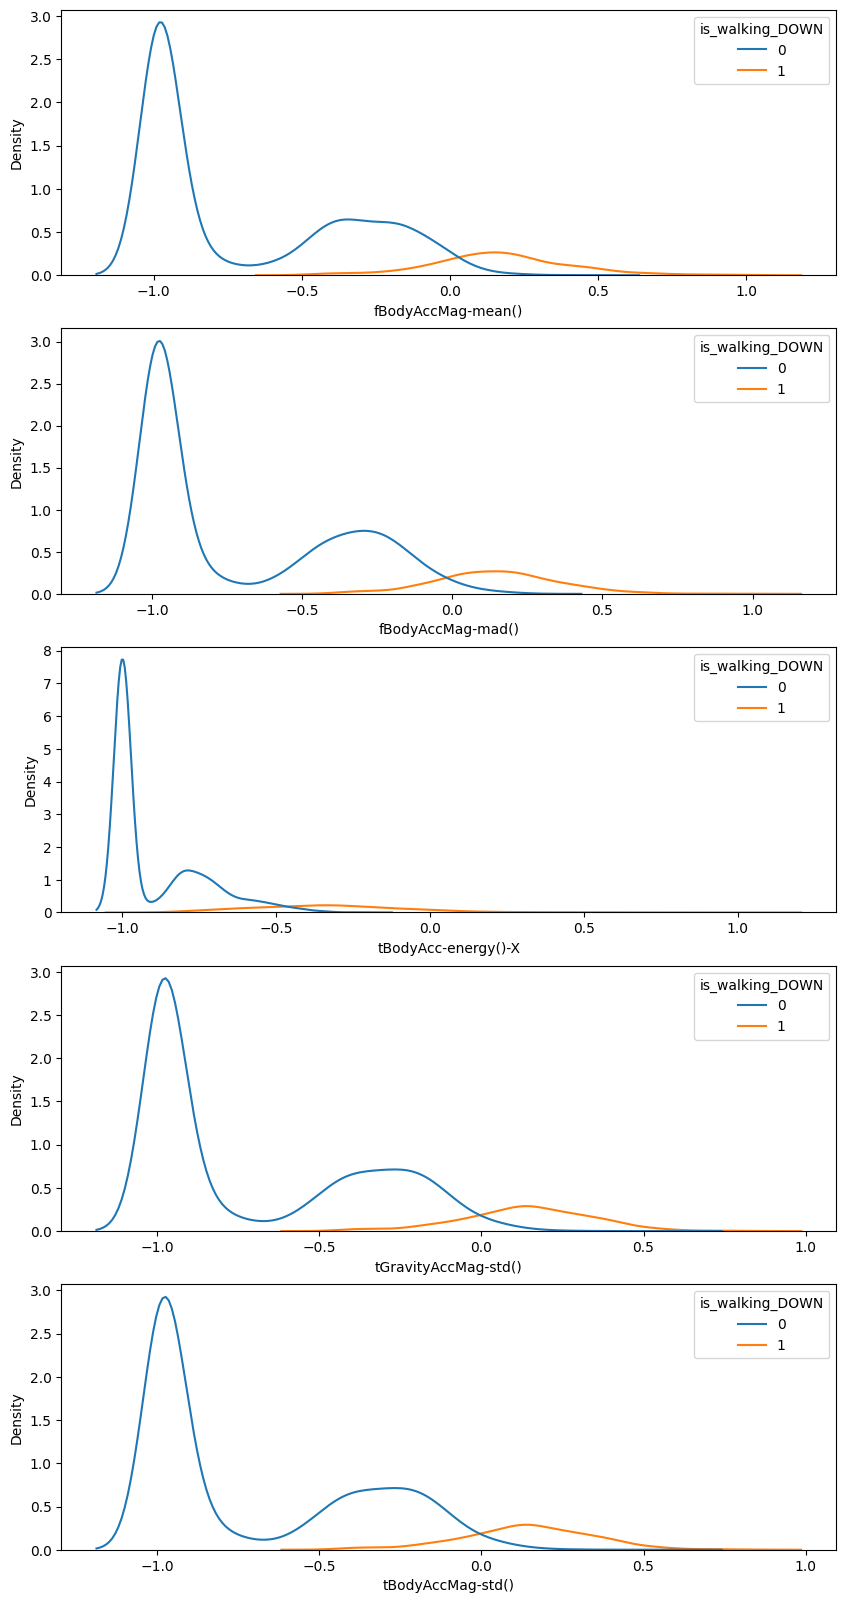

In [91]:
plt.figure(figsize=(10,20))
for i in range(5):
    plt.subplot(5, 1, i+1)
    sns.kdeplot(x=up5[i], hue='is_walking_DOWN', data=dynamic)
plt.show()

#### 4) feature 그룹별 분석

* 결과 merge

In [92]:
features_merge = pd.merge(features, importance, on='feature_name')
features_merge.tail()

,sensor,agg,axis,feature_name,feature_importance
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000916
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000315
558,angle,X,gravityMean,"angle(X,gravityMean)",0.001576
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.003707
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.001066


* sensor 별 중요도

<Axes: ylabel='sensor'>

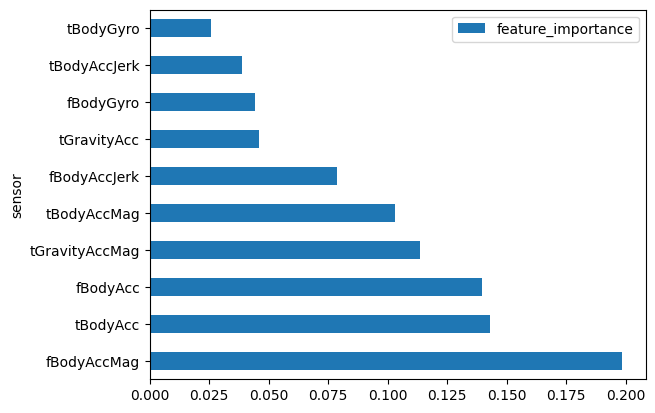

In [93]:
sensor_imp = features_merge.groupby(by='sensor', as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_imp.head(10).set_index('sensor').plot(kind='barh')

* sensor + agg 별 중요도

<Axes: ylabel='together'>

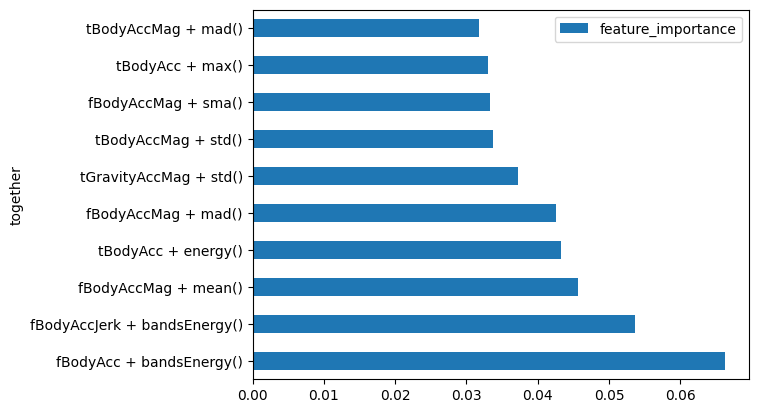

In [94]:
sensor_agg_imp = features_merge.groupby(by=['sensor', 'agg'], as_index=False)['feature_importance'].sum().sort_values(by='feature_importance', ascending=False)
sensor_agg_imp['together'] = sensor_agg_imp['sensor'] + ' + ' + sensor_agg_imp['agg']
sensor_agg_imp.head(10).set_index('together').plot(kind='barh')

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다.

#### 1) 이름변경

In [95]:
print(feature_importance.shape)
print(feature_importance_dynamic.shape)
print(feature_importance_standing.shape)
print(feature_importance_sitting.shape)
print(feature_importance_laying.shape)
print(feature_importance_walking.shape)
print(feature_importance_walkingup.shape)
print(feature_importance_walkingdown.shape)

(561,)
(561,)
(561,)
(561,)
(561,)
(561,)
(561,)
(561,)


#### 2) 합치기

In [96]:
result = pd.DataFrame()
result['feature_names'] = list(x)
result['fi_dynamic'] = feature_importance_dynamic
result['fi_standing'] = feature_importance_standing
result['fi_sitting'] = feature_importance_sitting
result['fi_laying'] = feature_importance_laying
result['fi_walking'] = feature_importance_walking
result['fi_walkingup'] = feature_importance_walkingup
result['fi_walkingdown'] = feature_importance_walkingdown
result.head()

,feature_names,fi_dynamic,fi_standing,fi_sitting,fi_laying,fi_walking,fi_walkingup,fi_walkingdown
0,tBodyAcc-mean()-X,0.000018,0.000223,0.000296,0.000029,0.000106,0.000287,0.000117
1,tBodyAcc-mean()-Y,0.000009,0.000363,0.000567,0.000145,0.000198,0.000310,0.000469
2,tBodyAcc-mean()-Z,0.000000,0.000263,0.000413,0.000149,0.000185,0.000328,0.000098
3,tBodyAcc-std()-X,0.000038,0.006221,0.000707,0.000178,0.011663,0.006478,0.029259
4,tBodyAcc-std()-Y,0.000000,0.001981,0.000216,0.000384,0.000322,0.000418,0.000923


### (2) 저장하기
* joblib.dump를 이용하시오.
* 저장할 파일의 확장자는 보통 .pkl 입니다.

In [97]:
from joblib import dump

dump(result, 'feature_importances.pkl')

['feature_importances.pkl']

In [99]:
result.to_csv('feature_importances.csv', index=False)